In [64]:
import os

import numpy as np
import pandas as pd

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from confusion_matrix import calc_confusion_matrix_for_probas_and_threshold

from load_BERT_embeddings import load_arr_from_npz

# Plotting libraries
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', style='whitegrid', font_scale=1.25)

# Autoload changes in other files.
# Avoids restarting the Jupyter kernel each time you make a change to the imported code.
%load_ext autoreload
%autoreload 2


# Aight so I looked into it a little bit. Through the magic of packages 
# (and what’s already been given to us), I think doing the BERT road wouldn’t
# be too bad. Seems like the most complicated part is tokenizing 
# (which I think is the same thing as embedding) the inputs, but 
# the good news is that that shit’s already done for us. 
# Here’s a link that explains everything we’d have to do, via PyTorch:
# https://huggingface.co/docs/transformers/en/tasks/sequence_classification 

# Given we already have the embeddings of the training/test data,
# the general plan would be the following.

# 1. Split the data into training/test sets. 80/20 or so. 
# Need to do the same split for the BERT_embedded_x_train and the y_train
# thing.

# 2. Select hyper parameters (given that there are several hyper parameters 
# to choose from, we could do a K-fold search later on to select the best
# hyperparams).

# 3. Train based off embedded/y pairs. This may be the trickiest part, 
# as we have to format the data in a nice, PyTorch way, that I don’t really
# understand.

# 4. Evaluate (should be like one line of code).

# Overall, I think this mostly seems pretty reasonable, and the only things 
# that seem wack would be the normal things in these projects 
# (converting English talk to python code, making sure everything matches up in a nice way).

# Take a look at that link if you have some time



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
# Reading in training data
data_dir = "data_readinglevel"
x_train_df = pd.read_csv(os.path.join(data_dir, "x_train.csv"))
y_train_df = pd.read_csv(os.path.join(data_dir, "y_train.csv"))

xBERT_train_NH = load_arr_from_npz(os.path.join(data_dir, 'x_train_BERT_embeddings.npz'))

assert xBERT_train_NH.ndim == 2

N, n_cols = x_train_df.shape
N2, H = xBERT_train_NH.shape

assert N == N2

print(x_train_df.columns)


y_train_N = []
for curr_line in y_train_df['Coarse Label']:
    if curr_line == "Key Stage 2-3":
        y_train_N.append(0)
    elif curr_line == "Key Stage 4-5":
        y_train_N.append(1)
    else:
        raise Exception("incorrect formatted y_train.csv")
    

N3 = len(y_train_N)
assert N2 == N3



embedding_tuples = [tuple(row) for row in xBERT_train_NH]
unique_embeddings = set(embedding_tuples)

print(f"Total embeddings: {len(xBERT_train_NH)}")
print(f"Unique embeddings: {len(unique_embeddings)}")

Index(['author', 'title', 'passage_id', 'text', 'char_count', 'word_count',
       'sentence_count', 'avg_word_length', 'avg_sentence_length',
       'type_token_ratio', 'pronoun_freq', 'function_words_count',
       'punctuation_frequency', 'sentiment_polarity', 'sentiment_subjectivity',
       'readability_Kincaid', 'readability_ARI', 'readability_Coleman-Liau',
       'readability_FleschReadingEase', 'readability_GunningFogIndex',
       'readability_LIX', 'readability_SMOGIndex', 'readability_RIX',
       'readability_DaleChallIndex', 'info_characters_per_word',
       'info_syll_per_word', 'info_words_per_sentence',
       'info_type_token_ratio', 'info_characters', 'info_syllables',
       'info_words', 'info_wordtypes'],
      dtype='object')
Total embeddings: 5557
Unique embeddings: 5557


In [66]:
from sklearn.model_selection import train_test_split

x_train_MH, x_val_PH, y_train_M, y_val_P = train_test_split(
    xBERT_train_NH, y_train_N, test_size=0.2, random_state=42, stratify=y_train_N
)


x_train_MH = np.asarray(x_train_MH)
x_val_PH = np.asarray(x_val_PH)
y_train_M = np.asarray(y_train_M)
y_val_P = np.asarray(y_val_P)

assert x_train_MH.shape[0] == y_train_M.shape[0]
assert x_val_PH.shape[0] == y_val_P.shape[0]
assert x_train_MH.shape[1] == x_val_PH.shape[1]
assert x_train_MH.shape[0] + x_val_PH.shape[0] == N



print(x_train_MH)


[[ 0.03518136  0.09937337 -0.22709018 ... -0.07918218  0.54010749
   0.27213418]
 [-0.14885771  0.02155298  0.27808908 ... -0.17967992  0.39782602
   0.52256995]
 [-0.42366901  0.28810751 -0.23735306 ... -0.19105725  0.73079932
   0.48521158]
 ...
 [-0.04092853 -0.03019948  0.24357484 ...  0.13334557  0.33085275
  -0.00609004]
 [-0.16997463  0.43625075 -0.32849273 ... -0.01950504  0.55221069
   0.35035148]
 [-0.20631509  0.12396508 -0.63968402 ...  0.14260195  0.42426026
   0.16411524]]


In [67]:
# layer_szs = [512, 256, 128]
# layer_szs = [256,128]
layer_szs = [512, 256]
print(layer_szs)

[512, 256]


In [68]:
from sklearn.preprocessing import StandardScaler


steps = [
    ('scaler', StandardScaler()),  # Normalize BERT embeddings to mean 0 var 1
    ('trainer', MLPClassifier(max_iter=10000,shuffle=True, random_state=511, 
                              verbose=0, 
                              activation='relu',
                              solver='adam',
                              learning_rate='adaptive',
                              hidden_layer_sizes=layer_szs, tol=0.01,
                              early_stopping=True)),
]

pipeline = Pipeline(steps)

grid = dict()
alphas = np.logspace(-4,4,num=7)
# grid['trainer__activation'] = ['relu', 'logistic']
# grid['trainer__activation'] = ['relu']
# grid['trainer__solver'] = ['sgd']
# grid['trainer__solver'] = ['adam']
grid['trainer__alpha'] = alphas




n_folds = 10
folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=70012)

g = GridSearchCV(
    pipeline,
    param_grid=grid,
    scoring=['roc_auc', 'neg_log_loss'], 
    cv=folds,
    n_jobs=-1,
    return_train_score=True,
    refit='roc_auc',  
    verbose=0  
)

# Fit the model on BERT embeddings
g.fit(x_train_MH, y_train_M)
print("Done with gridsearch")


Done with gridsearch


In [81]:
g.best_params_

{'trainer__alpha': 21.54434690031882}

\begin{tabular}{lrr}
\toprule
Predicted & 0 & 1 \\
True &  &  \\
\midrule
0 & 142 & 59 \\
1 & 66 & 178 \\
\bottomrule
\end{tabular}

fnxs shape: (66, 768)


<Figure size 1000x1000 with 0 Axes>

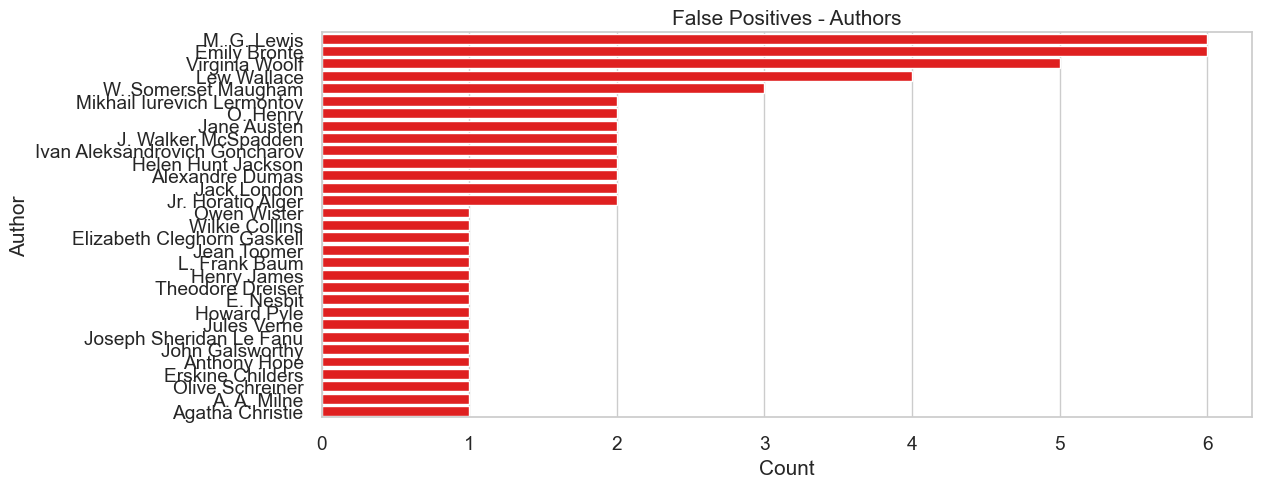

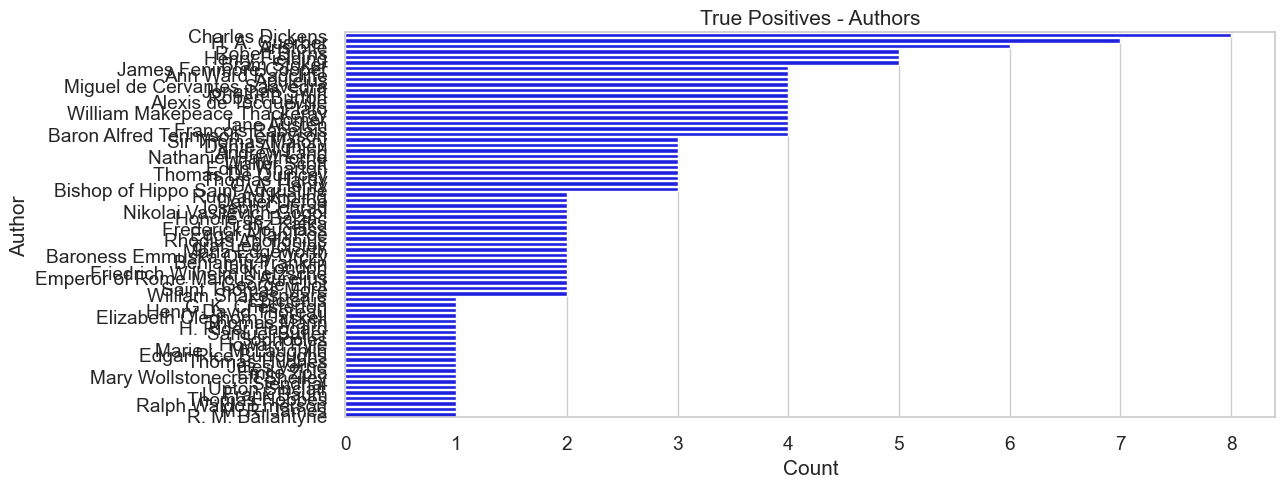

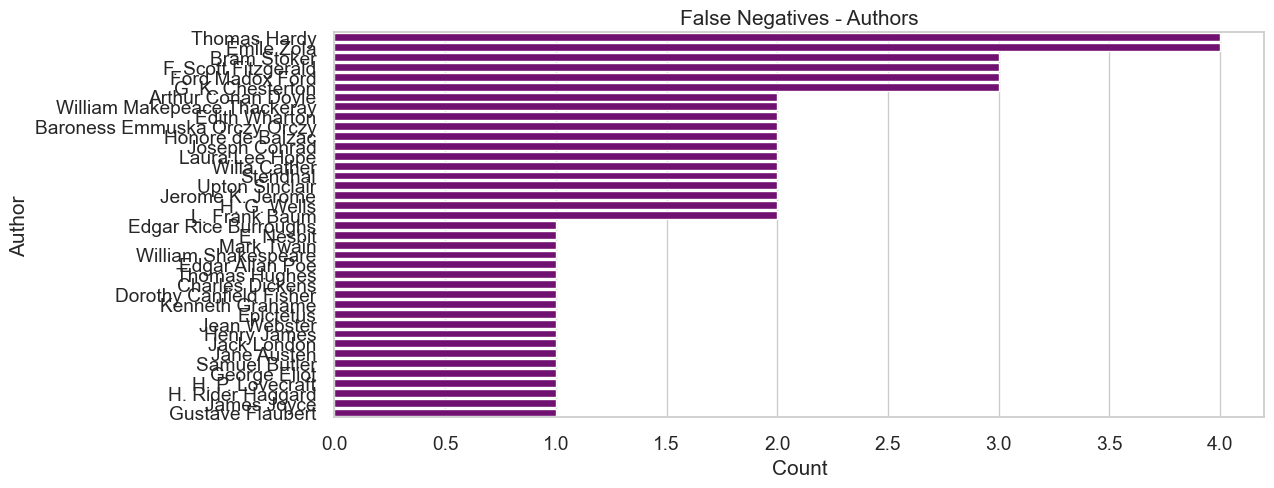

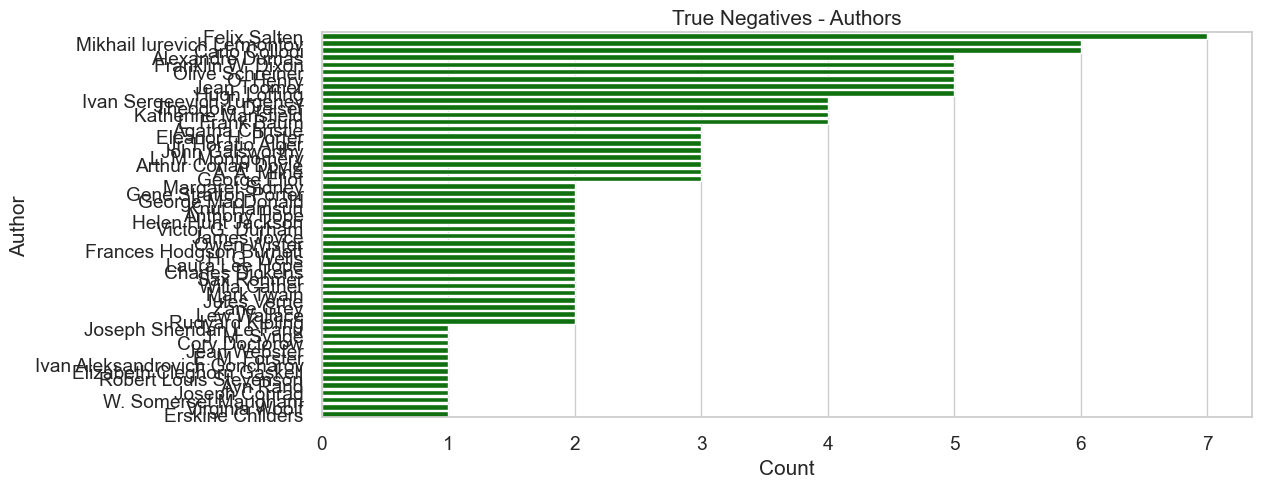

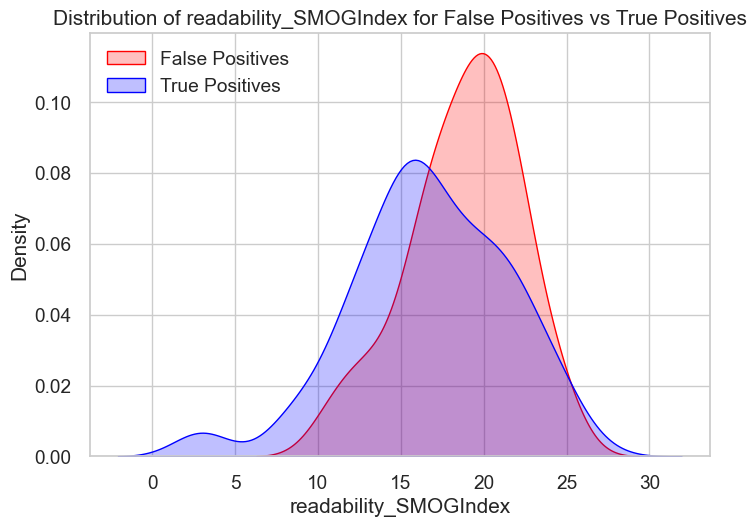

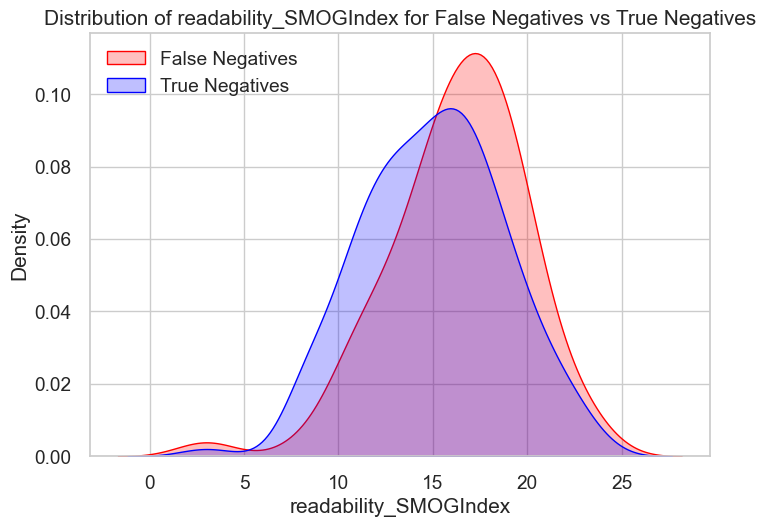

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              text  Coarse Label
                                                    He saw that to obtain a  sight of his Mistress by open means was out of the question; and both  Himself and Matilda had consumed the night, in endeavouring to invent  some plan, whose event might be more successful. Such was their  employment, when a Lay-Brother entered the Abbot's Cell, and informed  him that a Woman calling herself Jacintha Zuniga requested audience for  a few minutes. Ambrosio was by no means dis

In [84]:
best_index = np.argmax(g.cv_results_["mean_test_roc_auc"])

best_fold = np.argmax([g.cv_results_[f'split{i}_test_roc_auc'][best_index] for i in range(n_folds)])

best_estimator = g.best_estimator_

assert x_train_MH.shape[0] == y_train_M.shape[0]



cmats = []
x_val_dfs = []
val_idxs = []
y_val_dfs = []
yhat_val_dfs = []
# disregard train_idx
count = 0
for _, val_idx in folds.split(x_train_MH, y_train_M):
        
    x_val_df = np.asarray(x_train_MH)[val_idx]
    y_val_df = np.asarray(y_train_M)[val_idx]

    x_val_dfs.append(x_val_df)
    y_val_dfs.append(y_val_df)
    
    yhat_val_df = best_estimator.predict_proba(x_val_df)[:,1]
    
    yhat_val_dfs.append(yhat_val_df)
    
    cmats.append(calc_confusion_matrix_for_probas_and_threshold(y_val_df, yhat_val_df, 0.5))
    count += 1
    val_idxs.append(val_idx)
    
chosen_idx = 4
print(cmats[chosen_idx].to_latex()) # chosen arbitrarily



chosen_xs = x_val_dfs[chosen_idx]
chosen_ys = y_val_dfs[chosen_idx]
chosen_yhats = yhat_val_dfs[chosen_idx]
chosen_cmat = cmats[chosen_idx]
chosen_vals = val_idxs[chosen_idx]

chosen_preds = (chosen_yhats >= 0.5).astype(int)
incorrect_idxs = np.where(chosen_preds != chosen_ys)[0]

fns = np.where((chosen_preds == 0) & (chosen_ys == 1))[0]
tns = np.where((chosen_preds == 0) & (chosen_ys == 0))[0]
fps = np.where((chosen_preds == 1) & (chosen_ys == 0))[0]
tps = np.where((chosen_preds == 1) & (chosen_ys == 1))[0]



tnxs = chosen_xs[tns]
fnxs = chosen_xs[fns]
fpxs = chosen_xs[fps]
tpxs = chosen_xs[tps]

print(f"fnxs shape: {np.shape(fnxs)}")

def get_indices_from_embeddings(embeddings):
    indices = []
    # Find the index of the embedding in the full dataset
    for e in embeddings:
        matching_index = np.where((xBERT_train_NH == e).all(axis=1))[0]

        assert len(matching_index) == 1
        
        indices.append(matching_index[0])
    
    return indices
    print(f'matching_index[0]   {matching_index[0]}')
    # Retrieve the corresponding text
    return x_train_df.iloc[matching_index[0]]['text']



fn_idxs = get_indices_from_embeddings(fnxs)
tn_idxs = get_indices_from_embeddings(tnxs)
fp_idxs = get_indices_from_embeddings(fpxs)
tp_idxs = get_indices_from_embeddings(tpxs)


# wrong_idxs = x_train_df[x_train_df['text'].isin(wrongxs)].index

# METRIC = 'sentiment_polarity'
# METRIC = 'word_count'
# METRIC = 'readability_DaleChallIndex'
# METRIC = 'function_words_count'
# METRIC = 'pronoun_freq'
# METRIC = 'readability_GunningFogIndex'
# METRIC = 'avg_word_length'
# METRIC = 'avg_sentence_length'
# METRIC = 'readability_LIX'
# METRIC = 'readability_RIX'
METRIC = 'author'
# METRIC = 'readability_SMOGIndex'


tp_metrics = x_train_df.loc[tp_idxs, METRIC]
tn_metrics = x_train_df.loc[tn_idxs, METRIC]
fp_metrics = x_train_df.loc[fp_idxs, METRIC]
fn_metrics = x_train_df.loc[fn_idxs, METRIC]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))


# Function to plot categorical distributions
def plot_author_distribution(metrics, title, color):
    plt.figure(figsize=(12, 5))
    sns.countplot(y=metrics, order=metrics.value_counts().index, color=color)
    plt.xlabel("Count")
    plt.ylabel("Author")
    plt.title(title)
    plt.show()

# # Plot author distributions
plot_author_distribution(fp_metrics, "False Positives - Authors", "red")
plot_author_distribution(tp_metrics, "True Positives - Authors", "blue")
plot_author_distribution(fn_metrics, "False Negatives - Authors", "purple")
plot_author_distribution(tn_metrics, "True Negatives - Authors", "green")


METRIC = 'readability_SMOGIndex'


tp_metrics = x_train_df.loc[tp_idxs, METRIC]
tn_metrics = x_train_df.loc[tn_idxs, METRIC]
fp_metrics = x_train_df.loc[fp_idxs, METRIC]
fn_metrics = x_train_df.loc[fn_idxs, METRIC]

# # Plot histogram with KDE
sns.kdeplot(fp_metrics, label="False Positives", fill=True, color="red")
sns.kdeplot(tp_metrics, label="True Positives", fill=True, color="blue")

plt.xlabel(f"{METRIC}")
plt.ylabel("Density")
plt.title(f"Distribution of {METRIC} for False Positives vs True Positives")
plt.legend()
plt.show()


sns.kdeplot(fn_metrics, label="False Negatives", fill=True, color="red")
sns.kdeplot(tn_metrics, label="True Negatives", fill=True, color="blue")

plt.xlabel(f"{METRIC}")
plt.ylabel("Density")
plt.title(f"Distribution of {METRIC} for False Negatives vs True Negatives")
plt.legend()
plt.show()

hardy_texts = x_train_df[x_train_df['author'] == 'M. G. Lewis']

hardy_labeled_texts = hardy_texts.merge(y_train_df, on='passage_id', how='left')

# pd.set_option('display.max_colwidth', None)

# # Print all texts with their labels
print(hardy_labeled_texts[['text', 'Coarse Label']].to_string(index=False))

# import textwrap

# # Define a function to wrap long text
# def wrap_text(text, width=80):
#     return "\n".join(textwrap.wrap(text, width=width))

# # Apply the wrap_text function to the 'text' column
# hardy_labeled_texts['wrapped_text'] = hardy_labeled_texts['text'].apply(lambda x: wrap_text(x, width=80))

# # Now print the wrapped text with the label
# print(hardy_labeled_texts[['wrapped_text', 'Coarse Label']].to_string(index=False))

In [70]:
yhat_proba_P = g.predict_proba(x_val_PH)[:,1]

calc_confusion_matrix_for_probas_and_threshold(y_val_P, yhat_proba_P, 0.5)

Predicted,0,1
True,,
0,367,135
1,188,422


baseline__AUROC, GridSearchCV__AUROC (0.5, 0.7945202795375874)


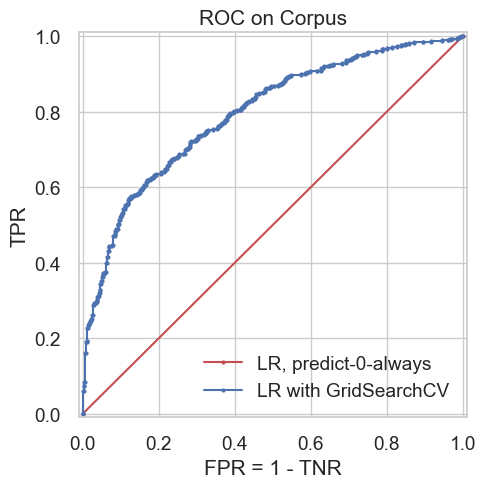

In [71]:
from sklearn.metrics import roc_auc_score, roc_curve

plt.subplots(nrows=1, ncols=1, figsize=(5,5));

yhat_baseline_P = np.zeros_like(y_val_P)

# Create ROC curve for predict-0-always baseline
fpr, tpr, t2 = roc_curve(y_val_P, yhat_baseline_P)
baseline__AUROC = roc_auc_score(y_val_P, yhat_baseline_P)
plt.plot(fpr, tpr, 'r.-', label='LR, predict-0-always')



# Create ROC curve for pipeline
fpr, tpr, t2 = roc_curve(y_val_P, yhat_proba_P)
GridSearchCV__AUROC = roc_auc_score(y_val_P, yhat_proba_P)
plt.plot(fpr, tpr, 'b.-', label='LR with GridSearchCV')


# Formatting
plt.title("ROC on Corpus");
plt.xlabel('FPR = 1 - TNR');
plt.ylabel('TPR');
plt.legend(loc='lower right');
B = 0.01
plt.xlim([0 - B, 1 + B]);
plt.ylim([0 - B, 1 + B]);
print(f'baseline__AUROC, GridSearchCV__AUROC {baseline__AUROC, GridSearchCV__AUROC}')

In [72]:

xBERT_test_QH = load_arr_from_npz(os.path.join(data_dir, 'x_test_BERT_embeddings.npz'))

assert xBERT_test_QH.ndim == 2

N4, Q = xBERT_train_NH.shape

assert N == N4


y_test_P = g.best_estimator_.predict_proba(xBERT_test_QH)[:,1]
y_test_df = pd.DataFrame(y_test_P)
y_test_df.to_csv('yproba1_test.txt',index=False, header=False, sep='\n')

s = np.loadtxt('yproba1_test.txt')
s.shape

(1197,)

In [63]:
# report 1D

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve


best_index = np.argmax(g.cv_results_["mean_test_roc_auc"])

best_fold = np.argmax([g.cv_results_[f'split{i}_test_roc_auc'][best_index] for i in range(n_folds)])

best_estimator = g.best_estimator_

cmats = []
x_val_dfs = []
val_idxs = []
y_val_dfs = []
yhat_val_dfs = []
# disregard train_idx
count = 0
for _, val_idx in folds.split(corpus_M, y_train_M):
        
    x_val_df = np.asarray(corpus_N)[val_idx]
    y_val_df = np.asarray(y_N)[val_idx]

    x_val_dfs.append(x_val_df)
    y_val_dfs.append(y_val_df)
    
    yhat_val_df = best_estimator.predict_proba(x_val_df)[:,1]
    
    yhat_val_dfs.append(yhat_val_df)
    
    cmats.append(calc_confusion_matrix_for_probas_and_threshold(y_val_df, yhat_val_df, 0.5))
    count += 1
    val_idxs.append(val_idx)
# print(cmats[4].to_latex()) # chosen arbitrarily

chosen_idx = 4

chosen_xs = x_val_dfs[chosen_idx]
chosen_ys = y_val_dfs[chosen_idx]
chosen_yhats = yhat_val_dfs[chosen_idx]
chosen_cmat = cmats[chosen_idx]
chosen_vals = val_idxs[chosen_idx]

mu = np.mean(np.vectorize(len)(chosen_xs))
sigma = np.std(np.vectorize(len)(chosen_xs))

# print(f'(mu, sigma)   {(mu, sigma)}')


chosen_preds = (chosen_yhats >= 0.5).astype(int)
incorrect_idxs = np.where(chosen_preds != chosen_ys)[0]

fns = np.where((chosen_preds == 0) & (chosen_ys == 1))[0]
tns = np.where((chosen_preds == 0) & (chosen_ys == 0))[0]
fps = np.where((chosen_preds == 1) & (chosen_ys == 0))[0]
tps = np.where((chosen_preds == 1) & (chosen_ys == 1))[0]

assert len(tps) == 214



tnxs = chosen_xs[tns]
fnxs = chosen_xs[fns]
fpxs = chosen_xs[fps]
tpxs = chosen_xs[tps]
wrongxs = chosen_xs[incorrect_idxs]
wrongys = chosen_ys[incorrect_idxs]

# wrong__len_mu = np.mean(np.vectorize(len)(wrongxs))
# wrong__lensigma = np.std(np.vectorize(len)(wrongxs))

# print(f'wrongmu, wrongsigma   {wrong__len_mu, wrong__lensigma}')


fn_idxs = x_train_df[x_train_df['text'].isin(fnxs)].index
tn_idxs = x_train_df[x_train_df['text'].isin(tnxs)].index
fp_idxs = x_train_df[x_train_df['text'].isin(fpxs)].index
tp_idxs = x_train_df[x_train_df['text'].isin(tpxs)].index


# wrong_idxs = x_train_df[x_train_df['text'].isin(wrongxs)].index

    # METRIC = 'sentiment_polarity'
    # METRIC = 'word_count'
    # METRIC = 'readability_DaleChallIndex'
    # METRIC = 'function_words_count'
    # METRIC = 'pronoun_freq'
    # METRIC = 'readability_GunningFogIndex'
    # METRIC = 'avg_word_length'
METRIC = 'avg_sentence_length'
# METRIC = 'readability_LIX'
# METRIC = 'author'

tp_metrics = x_train_df.loc[tp_idxs, METRIC]
tn_metrics = x_train_df.loc[tn_idxs, METRIC]
fp_metrics = x_train_df.loc[fp_idxs, METRIC]
fn_metrics = x_train_df.loc[fn_idxs, METRIC]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))

    # Plot histogram with KDE
    # sns.kdeplot(fp_metrics, label="False Positives", fill=True, color="red")
    # sns.kdeplot(tp_metrics, label="True Positives", fill=True, color="blue")

    # plt.xlabel(f"{METRIC}")
    # plt.ylabel("Density")
    # plt.title(f"Distribution of {METRIC} for False Positives vs True Positives")
    # plt.legend()
    # plt.show()


sns.kdeplot(fn_metrics, label="False Negatives", fill=True, color="red")
sns.kdeplot(tn_metrics, label="True Negatives", fill=True, color="blue")

plt.xlabel(f"{METRIC}")
plt.ylabel("Density")
plt.title(f"Distribution of {METRIC} for False Negatives vs True Negatives")
plt.legend()
plt.show()


NameError: name 'corpus_M' is not defined